In [71]:
%load_ext autoreload
%autoreload 2

import pynwb
import numpy as np

# pip install python-intervals (NOT 'intervals')
import intervals as iv
import query_helpers as qu

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'lines.solid_capstyle': 'butt'})
mdates.rcParams.update({'date.autoformatter.microsecond': '%H:%M:%S.%f'})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Todo
- behavior (position/speed) indexed by time, and not by epoch name
    -requires concatenating behav on import
- interpolate position at spike times (instead of using searchsorted)

### Data import and analysis parameters

In [155]:
# what data to analyze
d = {}
d['anim'] = 'Bon'
d['day'] = 4 # 1-indexed

d['epoch'] = 4 # 1-indexed
d['cluster_id'] = 30

# analysis configuration
c = {}
c['speed_threshold'] = 0.05 # m/s

### Read NWB file

In [146]:
animday = '{}{:02d}'.format(d['anim'], d['day'])
nwb_filename = './' + animday + '_test.nwb'

print('Loading file: %s' % nwb_filename)
io = pynwb.NWBHDF5IO(nwb_filename, mode='r')
nwbf = io.read()
 
sst = nwbf.session_start_time.timestamp()

Loading file: ./Bon04_test.nwb


### Get behavioral intervals to analyze (when speed threshold is met, e.g.)

In [147]:
speed_module_name = 'Speed d{:d} e{:d}'.format(d['day'], d['epoch']) # HACKY--we should query on epoch directly
speed = nwbf.modules['Behavior']['Speed'][speed_module_name]
speed_threshold_fn = lambda x: x > c['speed_threshold']

# select time intervals when speed threshold is met 
speed_gt_intervals = qu.intervals_from_continuous(speed.data[()], speed.timestamps[()], speed_threshold_fn)

### Select spikes during analysis intervals

#### Select all spikes for requested cluster

In [148]:
# Get cluster name
clname_idx = nwbf.units.colnames.index('cluster_name')
cluster_name = animday + ' ' + nwbf.units.columns[clname_idx][d['cluster_id']]
print('Cluster name = ' + cluster_name)

# Get spike times
spikes_t = nwbf.units['spike_times'][d['cluster_id']]
print('# of spikes = %d' % spikes_t.size)
print('Time of 1st/last spike (s): %0.4f / %0.4f \n' % (spikes_t[0], spikes_t[-1]))

# Get spike observation intervals
obs_IntervalSeries = nwbf.units['obs_intervals'][d['cluster_id']] # returns IntervalSeries
obs_intervals = qu.intervals_from_array(obs_IntervalSeries)

print('# of intervals = %d' % len(obs_intervals))
print('Spike Observation Intervals (s): ')
print(obs_intervals)
print()

assert qu.times_in_intervals(spikes_t, obs_intervals), 'Spike times found outside of observation intervals'

Cluster name = Bon04 d4 t11 c4
# of spikes = 2192
Time of 1st/last spike (s): 1136405915.9655 / 1136414146.9964 

# of intervals = 7
Spike Observation Intervals (s): 
[1136405805.0,1136407143.0] | [1136407261.0,1136408205.0] | [1136408283.0,1136409227.0] | [1136409364.0,1136410301.0] | [1136410378.0,1136411611.0] | [1136412194.0,1136413126.0] | [1136413313.0,1136414148.0]



#### Select spikes occurring during behavioral intervals

In [149]:
r_intervals = speed_gt_intervals & obs_intervals # intersection operator!
r_spikes = qu.times_in_intervals(spikes_t,speed_gt_intervals)

print('# of spikes = %d' % len(r_spikes))
print('Time of 1st/last spike (s): %0.4f / %0.4f \n' % (r_spikes[0], r_spikes[-1]))

print('# of intervals = %d' % len(r_intervals))
print()



# of spikes = 120
Time of 1st/last spike (s): 1136409393.1139 / 1136410206.8772 

# of intervals = 120



### Get animal location at spike times

In [150]:
position_module_name = 'Position d{:d} e{:d}'.format(d['day'], d['epoch']) # HACKY--we should query on epoch directly
position = nwbf.modules['Behavior']['Position'][position_module_name]
pos_data = position.data[()] # converts to numpy array, otherwise indexes below must be strictly increasing
pos_timestamps = position.timestamps[()]

# Get animal location at spike times (r_spikes)
r_pos_at_spikes_idx = np.searchsorted(pos_timestamps, r_spikes)
r_pos_at_spikes = pos_data[r_pos_at_spikes_idx, :]


# Get animal location during spike observation intervals (r_intervals) for rate normalization
r_pos_idx = qu.times_in_intervals(pos_timestamps, speed_gt_intervals, return_indices=True)
r_pos = pos_data[r_pos_idx, :]


### Plot spikes by location

Text(0.5,1,'Spike-position map for Bon d4 e4 c30, speed > 0.05 m/s')

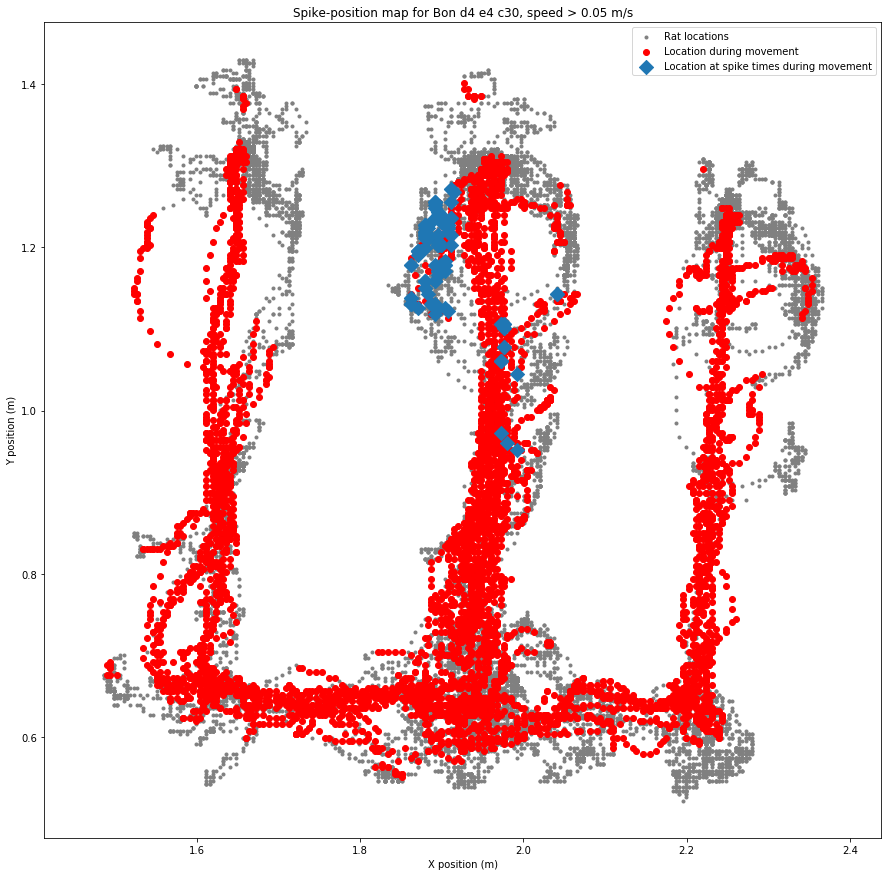

In [157]:
fig1 = plt.figure(1, figsize=(15,15))
ax1 = fig1.add_subplot(1,1,1)
ax1.axis('equal')

plt.scatter(pos_data[:,0], pos_data[:,1], marker='.', color='gray', label='Rat locations')
plt.scatter(r_pos[:,0], r_pos[:,1], marker='o', color='red', label='Location during movement')
plt.scatter(r_pos_at_spikes[:,0], r_pos_at_spikes[:,1], marker='D', s=100, label='Location at spike times during movement')

ax1.legend()
ax1.set_xlabel('X position (m)')
ax1.set_ylabel('Y position (m)')
ax1.set_title('Spike-position map for {} d{} e{} c{}, speed > {} m/s'.format(d['anim'], d['day'], d['epoch'], d['cluster_id'], c['speed_threshold']))

# position.data[0:10,0:2]
# position.timestamps[0:10]
# r_pos_ind_at_spikes
# r_pos_at_spikes